In [1]:
import numpy as np
import pandas as pd
from scipy import signal, optimize
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')



In [2]:
df_j = pd.read_csv('h.264+mp3_TS.csv')
xr = df_j['Jitter'][:147].values



We can split the dataset into three sub-datasets using a simple criterion as first derivative estimate using first difference to assess it. The goal is to detect when curve drastically goes up or down (where dataset should be split. First derivative is estimated as follow):

In [3]:
def func(x,a,b):
    return a*np.exp(b*x)

In [4]:
N = len(xr)
t = np.linspace(0,100,N)

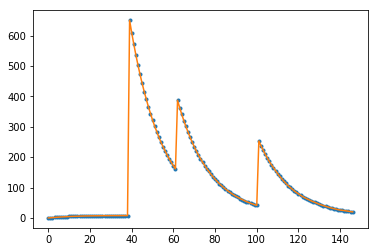

In [5]:
plt.plot(xr, '.')
plt.plot(xr, '-')

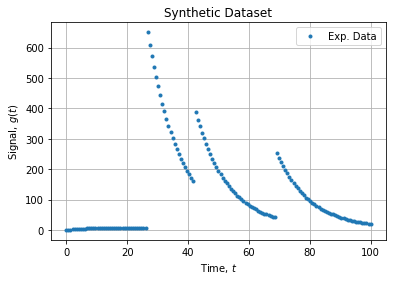

In [6]:
fig, axe = plt.subplots()
axe.plot(t, xr, '.', label='Exp. Data')
#axe.plot(t, x, '-', label='Exact')
axe.set_title("Synthetic Dataset")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Signal, $g(t)$")
axe.legend()
axe.grid()

In [7]:
dxrdt = np.abs(np.diff(xr)/np.diff(t))

In [8]:
xcrit = 60

In [9]:
q = np.where(dxrdt > xcrit)
q

(array([ 38,  61, 100], dtype=int64),)

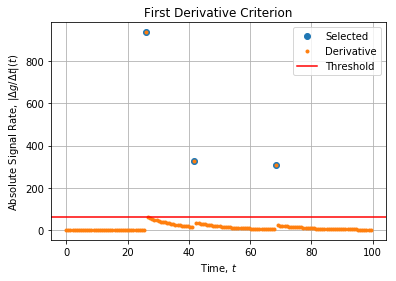

In [10]:
fig, axe = plt.subplots()
axe.plot(t[q[0]], dxrdt[q[0]], 'o', label='Selected')
axe.plot(t[:-1], dxrdt, '.', label='Derivative')
axe.axhline(xcrit, color="red", label='Threshold')
axe.set_title("First Derivative Criterion")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Absolute Signal Rate, $|\Delta g/\Delta t|(t)$")
axe.legend()
axe.grid()

In [11]:
idx = [0] + list(q[0]+1) + [t.size]
idx

[0, 39, 62, 101, 147]

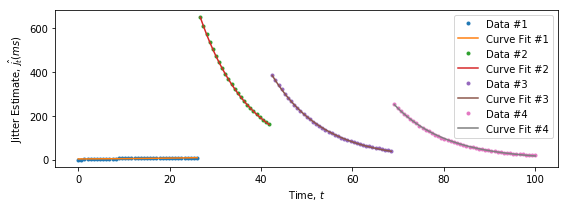

In [12]:
trials = []
fig, axe = plt.subplots(figsize=(8,3))
for k, (i, j) in enumerate(zip(idx[:-1], idx[1:])):
    p, s = optimize.curve_fit(func, t[i:j]-t[i], xr[i:j])
    axe.plot(t[i:j], xr[i:j], '.', label="Data #{}".format(k+1))
    axe.plot(t[i:j], func(t[i:j]-t[i], *p), label="Curve Fit #{}".format(k+1))
    trials.append({"n0": i, "n1": j, "t0": t[i], "a": p[0], "b": p[1],
                   "s_a": s[0,0], "s_b": s[1,1], "s_ab": s[0,1]})
#axe.set_title("Curve Fits")
axe.set_xlabel("Time, $t$")
axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
#axe.axes.yaxis.set_ticks([])
axe.legend()
fig.tight_layout()
fig.savefig('model.pdf', format='pdf', dpi=1500);
#axe.grid()

In [13]:
df = pd.DataFrame(trials)

In [14]:
df

,a,b,n0,n1,s_a,s_ab,s_b,t0
0,3.283712,0.038953,0,39,0.084392,-0.001276,2.241584e-05,0.000000
1,649.378018,-0.092873,39,62,0.065015,-0.000013,4.915240e-09,26.712329
2,383.561041,-0.088689,62,101,0.669652,-0.000173,8.915678e-08,42.465753
3,250.794387,-0.087335,101,147,0.531932,-0.000198,1.501234e-07,69.178082


In [36]:
df_rmse = []

for i, j in zip(idx[:-1], idx[1:]):
    p, s = optimize.curve_fit(func, t[i:j]-t[i], xr[i:j])
    rmse = np.sqrt(np.mean((xr[i:j]-func(t[i:j]-t[i], *p))**2))
    df_rmse.append({"n0": i, "n1": j, "rmse": rmse})
                   

In [37]:
df_rmse

[{'n0': 0, 'n1': 39, 'rmse': 1.1924897521482942},
 {'n0': 39, 'n1': 62, 'rmse': 0.45965506985033555},
 {'n0': 62, 'n1': 101, 'rmse': 1.6544712527994319},
 {'n0': 101, 'n1': 147, 'rmse': 1.5120723215295748}]

In [38]:
df_rmse = pd.DataFrame(df_rmse)
df_rmse

,n0,n1,rmse
0,0,39,1.192490
1,39,62,0.459655
2,62,101,1.654471
3,101,147,1.512072


In [39]:
df_rmse['rmse'].sum()

4.818688396327637

In [21]:
from sklearn.metrics import mean_absolute_error

In [22]:
df_mae = []

for i, j in zip(idx[:-1], idx[1:]):
    p, s = optimize.curve_fit(func, t[i:j]-t[i], xr[i:j])
    mae = mean_absolute_error(xr[i:j],(func(t[i:j]-t[i], *p)))
    df_mae.append({"n0": i, "n1": j, "mae": mae})

In [23]:
df_mae

[{'n0': 0, 'n1': 39, 'mae': 0.9882337468457058},
 {'n0': 39, 'n1': 62, 'mae': 0.3589806028231064},
 {'n0': 62, 'n1': 101, 'mae': 1.4339314870494557},
 {'n0': 101, 'n1': 147, 'mae': 1.285981847129147}]

In [24]:
df_mae = pd.DataFrame(df_mae)
df_mae

,mae,n0,n1
0,0.988234,0,39
1,0.358981,39,62
2,1.433931,62,101
3,1.285982,101,147


In [34]:
df_mae['mae'].sum()

4.067127683847415

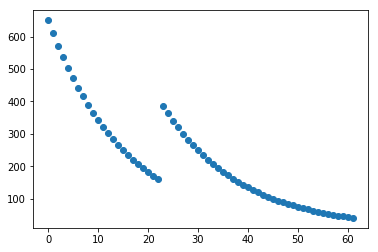

In [31]:
plt.plot(xr[39:101], 'o')

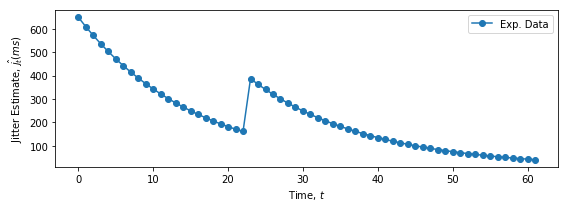

In [33]:
fig, axe = plt.subplots(figsize=(8,3))
axe.plot(xr[39:101], label='Exp. Data', ls='-', marker='o')


#l = [0, 73.5, 147]
#lx = ['0', '50', '100']
#axe.set_xticks(l)
#axe.set_xticklabels(lx)
axe.set_xlabel("Time, $t$")
#axe.axes.yaxis.set_ticks([])

axe.set_ylabel("Jitter Estimate, $\hat{j_t}(ms)$")
axe.legend()
fig.tight_layout()
fig.savefig('trace_extract.pdf', format='pdf', dpi=1500);
#axe.grid()